In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from brian2 import start_scope, prefs, run
from brian2 import NeuronGroup, PoissonGroup, Synapses, SpikeMonitor, StateMonitor, TimedArray
from brian2 import ms, mV, Hz

# Import libraries from outside folder
import sys
sys.path.append('../../lib/')

import brian2wrapper
import traces_lib

/home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


# Spiking Autoencoders

## 1.1 Shallow Random Sparse LIF, No Inhibition, No Plasticity

Logic:
* Have two populations $\vec{x}$ and $\vec{y}$
* They are connected bi-directionally to each other, but not laterally.
* There is upstream input $\vec{i}^{UP}$, and downstream input $\vec{i}^{DOWN}$

$$ \begin{eqnarray}
  \dot{y}_i &=& -\frac{y_i}{\tau} + W_{ij} x_j + i_i^{DOWN}\\
  \dot{x}_i &=& -\frac{x_i}{\tau} + U_{ij} y_j + i_i^{UP}
\end{eqnarray}$$

* Each unit will spike when it exceeds a standard threshold $T_0$ and be reset to zero.

Test:
* Produce a few patterns
* Present each pattern to $\vec{i}^{UP}$ via poisson process for extended periods of time
* Expect to observe convergence of system to fixed rates
* Measure rates of $\vec{y}$
* Input poisson process proportional to the observed rates to $\vec{i}^{DOWN}$
* Wait for convergence
* Compare rates of $\vec{x}$ to the original pattern

### Comments

* System very sensitive to input and average weight. Signal either does not propagate or blows up.
* Try adding inhibition

WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]


Generated 4 patterns
Pattern-neurons: [28, 30, 31, 33]
Pattern-overlaps: [9, 8, 8, 7, 6, 12]
typical potential change per input spike 12.5 mV
typical potential change per X spike 10. mV
typical potential change per Y spike 10. mV


<IPython.core.display.Javascript object>


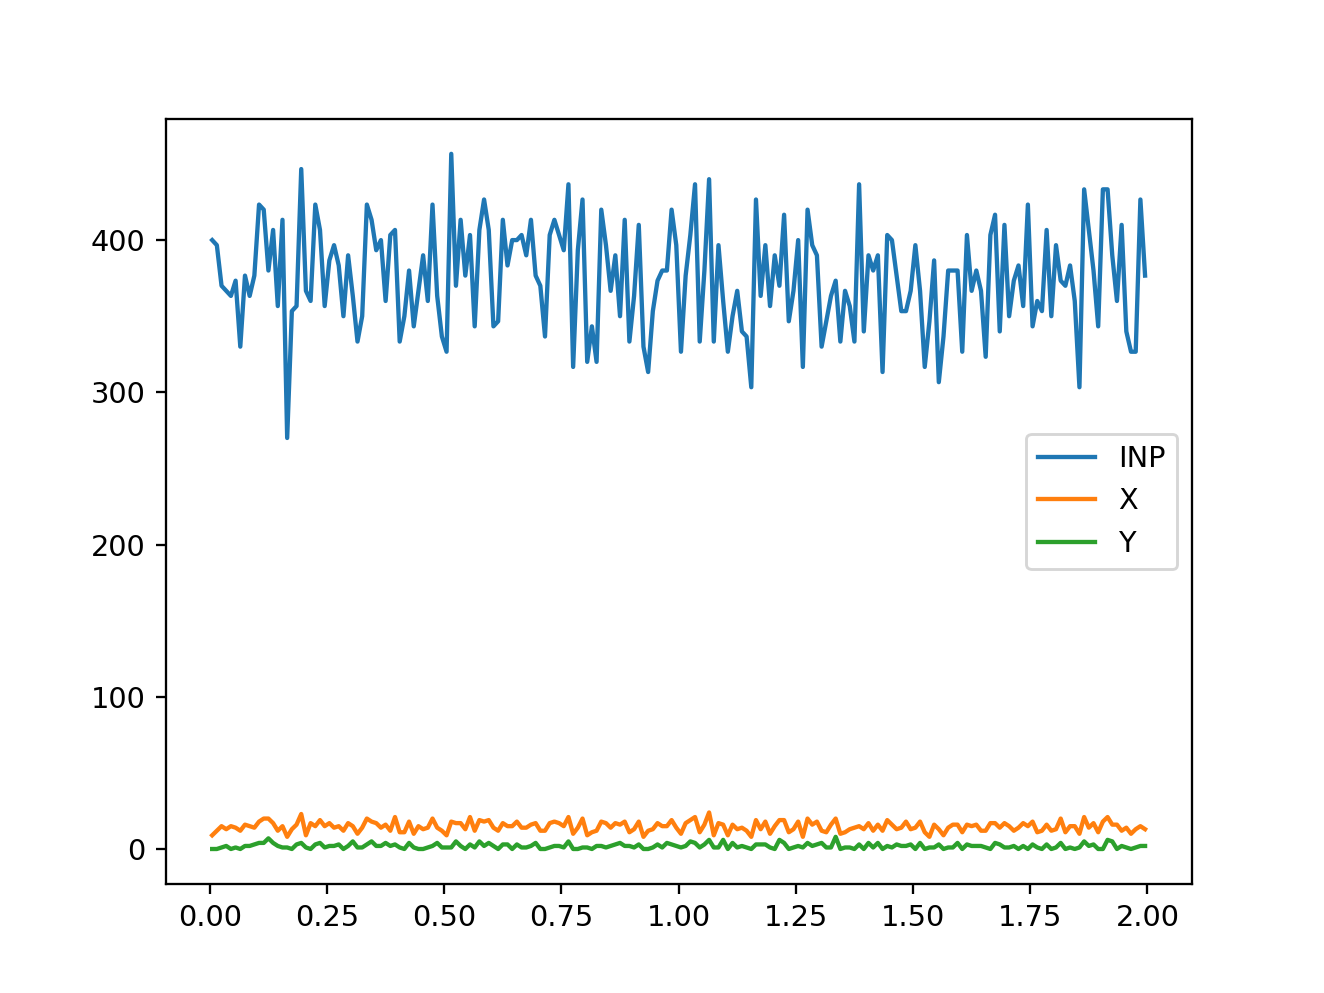

CPU times: user 2.84 s, sys: 21.5 ms, total: 2.86 s
Wall time: 2.86 s


In [2]:
%%time
p = {
    "N_X"       : 100,      # Number of neurons
    "N_Y"       : 100,      # Number of neurons
    "p_conn"    : 0.1,      # Connection probability
    "T0"        : 1.0,      # Average threshold
    "LIF_V_TAU" : 10*ms,    # Neuron leak timescale
    "LIF_V_0"   : 0.0*mV,   # Neuron base voltage
    "LIF_T_0"   : 50.0*mV,  # Neuron spike threshold
    
    "N_PT"      : 4,        # Number of patterns
    "P_PT"      : 0.3,       # Expected proportion of neurons that encode each pattern
    
    "INP_RATE"  : 400*Hz    # Input rate
}

#######################################
# Generate patterns
#######################################

patterns = [(np.random.uniform(0, 1, p['N_X']) < p['P_PT']).astype(int) for i in range(p['N_PT'])]

print('Generated', p['N_PT'], 'patterns')
print('Pattern-neurons:', [np.sum(pt) for pt in patterns])
print('Pattern-overlaps:', [np.sum(patterns[i]+patterns[j] == 2) for i in range(p['N_PT']) for j in range(i+1, p['N_PT'])])

DV_SPIKE_INP = p['LIF_T_0'] / 4                            # Voltage increase per input spike
DV_SPIKE_X   = p['LIF_T_0'] * p['N_X'] * p['p_conn'] / 5   # Voltage increase per system spike
DV_SPIKE_Y   = p['LIF_T_0'] * p['N_Y'] * p['p_conn'] / 5   # Voltage increase per system spike

print("typical potential change per input spike", DV_SPIKE_INP)
print("typical potential change per X spike", DV_SPIKE_X / p['N_X'] / p['p_conn'])
print("typical potential change per Y spike", DV_SPIKE_Y / p['N_Y'] / p['p_conn'])

#######################################
# Brian2 classes
#######################################

start_scope()
prefs.codegen.target = "numpy"

# Create neuronal populations
#G_INP = PoissonGroup(N_EXC, INPUT_FREQ_0 + INPUT_FREQ_MAX * np.ndarray.flatten(img1))
G_X   = brian2wrapper.NeuronGroupLIF(p['N_X'], p['LIF_V_0'], p['LIF_T_0'], p['LIF_V_TAU'])
G_Y   = brian2wrapper.NeuronGroupLIF(p['N_Y'], p['LIF_V_0'], p['LIF_T_0'], p['LIF_V_TAU'])
G_X_INP = PoissonGroup(p['N_X'], p['INP_RATE'] * patterns[0])

# Create synapses
S_XY = Synapses(G_X, G_Y, model='w : 1', on_pre='v_post += w * DV_SPIKE_X', method='exact')
S_YX = Synapses(G_Y, G_X, model='w : 1', on_pre='v_post += w * DV_SPIKE_Y', method='exact')
S_X_INP = Synapses(G_X_INP, G_X, on_pre='v_post += DV_SPIKE_INP', method='exact')

# Connect synapses:
S_X_INP.connect(j='i')
S_XY.connect(p=p['p_conn'])
S_YX.connect(p=p['p_conn'])

S_XY.w = '1.0/N_incoming'
S_YX.w = '1.0/N_incoming'

spikemon_INP = SpikeMonitor(G_X_INP)
spikemon_X = SpikeMonitor(G_X)
spikemon_Y = SpikeMonitor(G_Y)
spikemon = {
    "X" : spikemon_X,
    "Y" : spikemon_Y
}



#######################################
# Run sim
#######################################
START_TIME = 0*ms
RUN_TIME = 2000*ms

run(RUN_TIME)

#######################################
# Plots
#######################################
plt.figure()

spike_idxs = np.array(spikemon_INP.i)
spike_times = np.array(spikemon_INP.t)

avgNetworkRate_t, avgNetworkRate_r = traces_lib.spikes2rate(spike_times, START_TIME, RUN_TIME, 10*ms)
plt.plot(avgNetworkRate_t, avgNetworkRate_r / p['N_X'] / p['P_PT'], label='INP')

for pop in ["X", "Y"]:
    spike_idxs = np.array(spikemon[pop].i)
    spike_times = np.array(spikemon[pop].t)

    avgNetworkRate_t, avgNetworkRate_r = traces_lib.spikes2rate(spike_times, START_TIME, RUN_TIME, 10*ms)
    plt.plot(avgNetworkRate_t, avgNetworkRate_r / p['N_' + pop], label=pop)
plt.legend()
plt.show()

## 1.2 Shallow Random Sparse LIF, With Inhibition, No Plasticity

Connect an inhibitory population to each excitatory population. Still no lateral connections

**TODO:**
1) Plot average rates for X and Y
2) Plot 1-norm between pattern and max_normalized rate of X

WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
WARNING    /home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]


typical potential change due to INP->X EXC spike 50. mV
typical potential change due to X->Y EXC spike 10. mV
typical potential change due to Y->X EXC spike 10. mV
typical potential change due to X->X INH spike -40. mV
typical potential change due to Y->Y INH spike -40. mV
Generated 4 patterns
Pattern-neurons: [68, 60, 50, 59]
Pattern-overlaps: [19, 20, 23, 18, 16, 10]


<IPython.core.display.Javascript object>


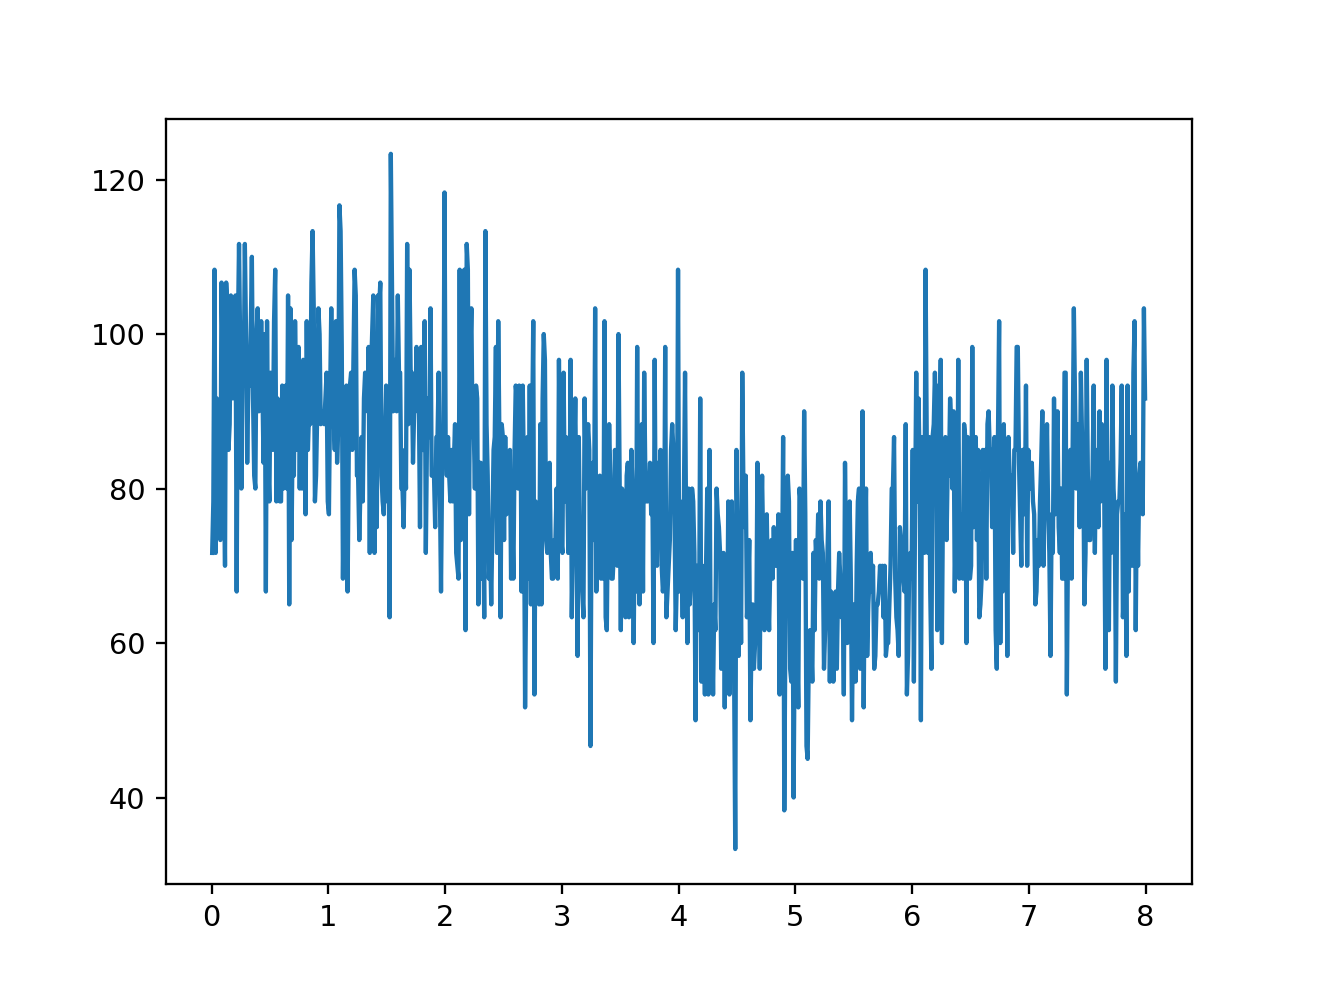

<IPython.core.display.Javascript object>


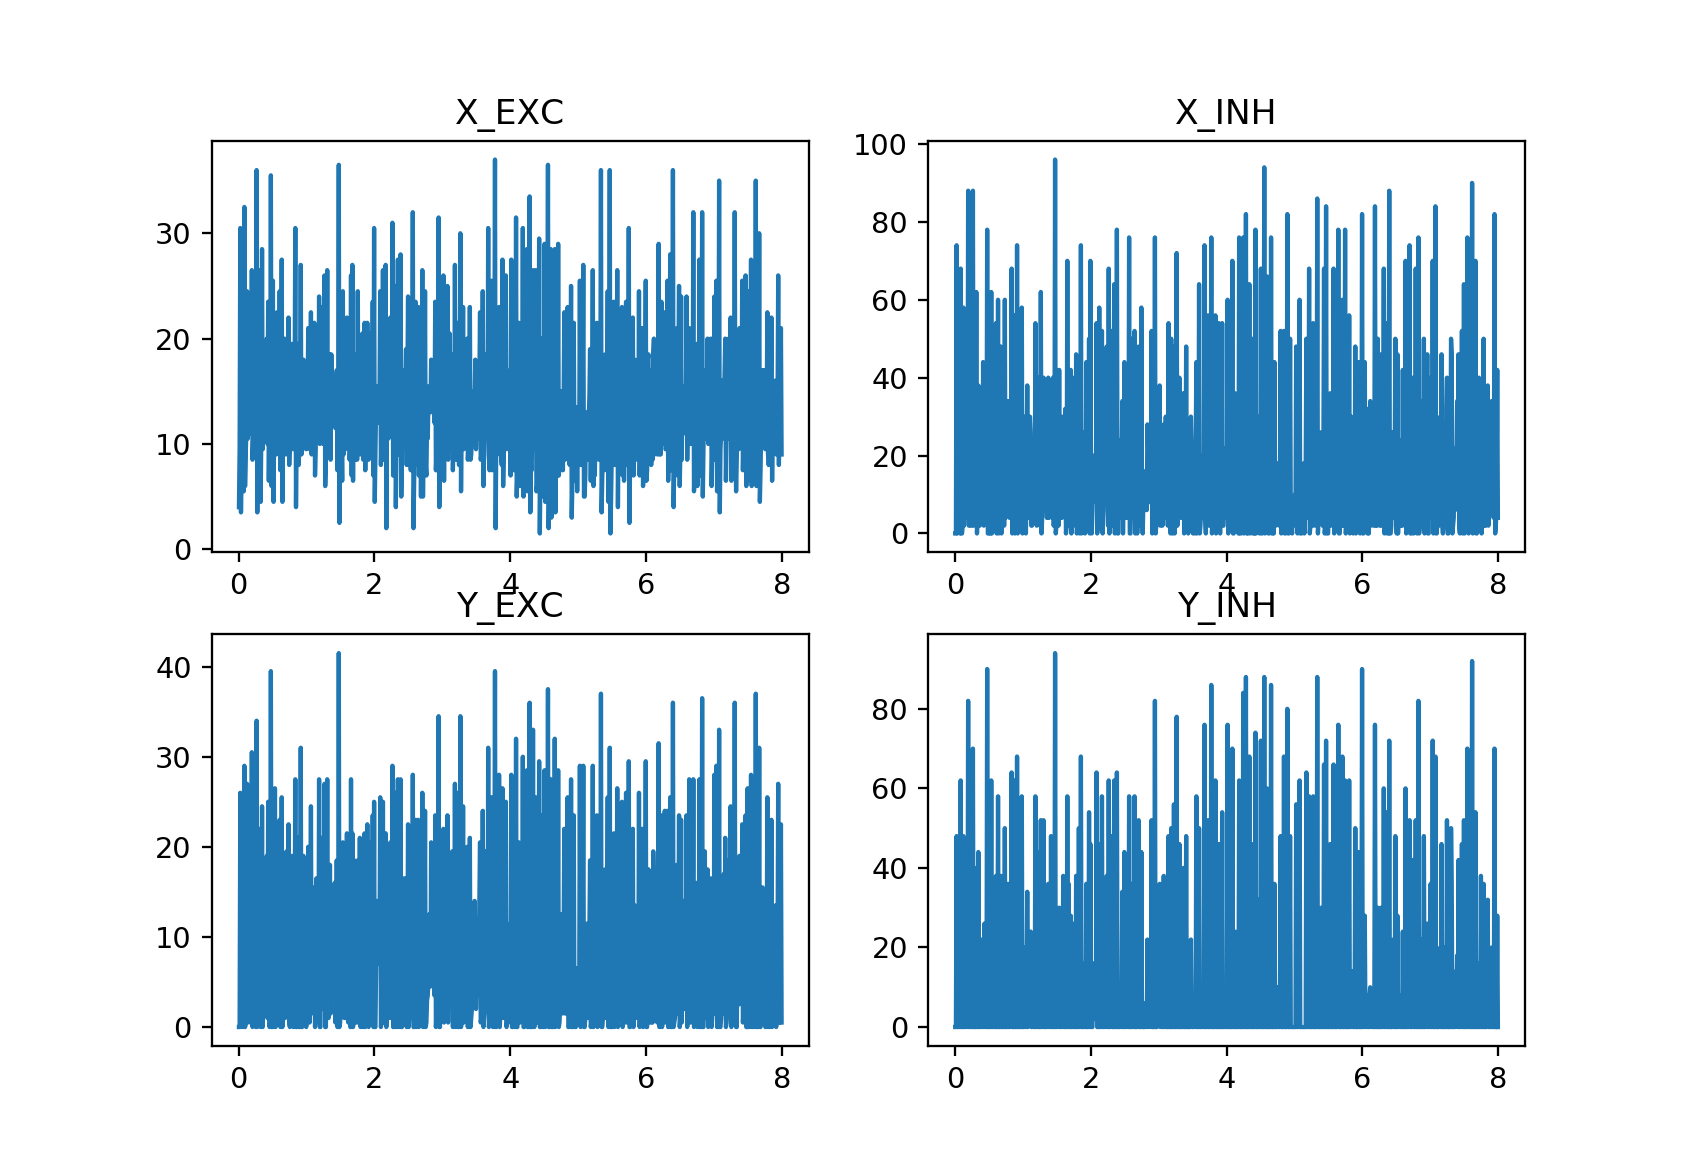

CPU times: user 16.6 s, sys: 10.8 ms, total: 16.6 s
Wall time: 16.6 s


In [3]:
%%time
p = {
    "N_X_EXC"   : 200,      # Number of neurons
    "N_Y_EXC"   : 200,      # Number of neurons
    "N_X_INH"   : 50,       # Number of neurons
    "N_Y_INH"   : 50,       # Number of neurons
    "p_conn"    : 0.1,      # Connection probability
    "T0"        : 1.0,      # Average threshold
    "LIF_V_TAU" : 10*ms,    # Neuron leak timescale
    "LIF_V_0"   : 0.0*mV,   # Neuron base voltage
    "LIF_T_0"   : 50.0*mV,  # Neuron spike threshold
    
    "N_PT"      : 4,        # Number of patterns
    "P_PT"      : 0.3,       # Expected proportion of neurons that encode each pattern
    
    "INP_RATE"  : 80*Hz    # Input rate
}

DV_SPIKE_INP   = p['LIF_T_0']
DV_SPIKE_XY_EXC = p['LIF_T_0'] * p['N_X_EXC'] * p['p_conn'] / 5   # Voltage increase per system spike
DV_SPIKE_YX_EXC = p['LIF_T_0'] * p['N_Y_EXC'] * p['p_conn'] / 5   # Voltage increase per system spike
DV_SPIKE_XX_INH = -4*p['LIF_T_0'] * p['N_X_INH'] * p['p_conn'] / 5   # Voltage increase per system spike
DV_SPIKE_YY_INH = -4*p['LIF_T_0'] * p['N_Y_INH'] * p['p_conn'] / 5   # Voltage increase per system spike

print("typical potential change due to INP->X EXC spike", DV_SPIKE_INP)
print("typical potential change due to X->Y EXC spike", DV_SPIKE_XY_EXC / p['N_X_EXC'] / p['p_conn'])
print("typical potential change due to Y->X EXC spike", DV_SPIKE_YX_EXC / p['N_Y_EXC'] / p['p_conn'])
print("typical potential change due to X->X INH spike", DV_SPIKE_XX_INH / p['N_X_INH'] / p['p_conn'])
print("typical potential change due to Y->Y INH spike", DV_SPIKE_YY_INH / p['N_Y_INH'] / p['p_conn'])

#######################################
# Generate patterns
#######################################

START_TIME = 0*ms
RUN_TIME_1_SIM = 2000*ms
RUN_TIME = RUN_TIME_1_SIM * p['N_PT']

patterns = [(np.random.uniform(0, 1, p['N_X_EXC']) < p['P_PT']).astype(int) for i in range(p['N_PT'])]

rates_all = np.array(patterns) * p['INP_RATE']

# NOTE: The poisson rate is changed with time step dt, resulting in new input
rateTimedArray = TimedArray(rates_all, dt = RUN_TIME_1_SIM)

print('Generated', p['N_PT'], 'patterns')
print('Pattern-neurons:', [np.sum(pt) for pt in patterns])
print('Pattern-overlaps:', [np.sum(patterns[i]+patterns[j] == 2) for i in range(p['N_PT']) for j in range(i+1, p['N_PT'])])

#######################################
# Brian2 classes
#######################################

start_scope()
prefs.codegen.target = "numpy"

# Create neuronal populations
G_X_INP = PoissonGroup(p['N_X_EXC'], rates="rateTimedArray(t, i)")
G_X_EXC = brian2wrapper.NeuronGroupLIF(p['N_X_EXC'], p['LIF_V_0'], p['LIF_T_0'], p['LIF_V_TAU'])
G_Y_EXC = brian2wrapper.NeuronGroupLIF(p['N_Y_EXC'], p['LIF_V_0'], p['LIF_T_0'], p['LIF_V_TAU'])
G_X_INH = brian2wrapper.NeuronGroupLIF(p['N_X_INH'], p['LIF_V_0'], p['LIF_T_0'], p['LIF_V_TAU'])
G_Y_INH = brian2wrapper.NeuronGroupLIF(p['N_Y_INH'], p['LIF_V_0'], p['LIF_T_0'], p['LIF_V_TAU'])


# Create synapses
S_X_INP = Synapses(G_X_INP, G_X_EXC, on_pre='v_post += DV_SPIKE_INP', method='exact')
S_XY    = Synapses(G_X_EXC, G_Y_EXC, model='w : 1', on_pre='v_post += w*DV_SPIKE_XY_EXC', method='exact')
S_YX    = Synapses(G_Y_EXC, G_X_EXC, model='w : 1', on_pre='v_post += w*DV_SPIKE_YX_EXC', method='exact')
S_XX_EI = Synapses(G_X_EXC, G_X_INH, model='w : 1', on_pre='v_post += w*DV_SPIKE_XY_EXC', method='exact')
S_XX_IE = Synapses(G_X_INH, G_X_EXC, model='w : 1', on_pre='v_post += w*DV_SPIKE_XX_INH', method='exact')
S_YY_EI = Synapses(G_Y_EXC, G_Y_INH, model='w : 1', on_pre='v_post += w*DV_SPIKE_YX_EXC', method='exact')
S_YY_IE = Synapses(G_Y_INH, G_Y_EXC, model='w : 1', on_pre='v_post += w*DV_SPIKE_YY_INH', method='exact')

# Connect synapses:
S_X_INP.connect(j='i')
S_XY.connect(p=p['p_conn'])
S_YX.connect(p=p['p_conn'])
S_XX_EI.connect(p=p['p_conn'])
S_XX_IE.connect(p=p['p_conn'])
S_YY_EI.connect(p=p['p_conn'])
S_YY_IE.connect(p=p['p_conn'])

S_XY.w = '1.0/N_incoming'
S_YX.w = '1.0/N_incoming'
S_XX_EI.w = '1.0/N_incoming'
S_XX_IE.w = '1.0/N_incoming'
S_YY_EI.w = '1.0/N_incoming'
S_YY_IE.w = '1.0/N_incoming'

sp_INP = SpikeMonitor(G_X_INP)
sp_X_EXC = SpikeMonitor(G_X_EXC)
sp_X_INH = SpikeMonitor(G_X_INH)
sp_Y_EXC = SpikeMonitor(G_Y_EXC)
sp_Y_INH = SpikeMonitor(G_Y_INH)

spikemon = {
    "X" : {
        "EXC" : sp_X_EXC,
        "INH" : sp_X_INH},
    "Y" : {
        "EXC" : sp_Y_EXC,
        "INH" : sp_Y_INH}
}

#######################################
# Run sim
#######################################

run(RUN_TIME)

#######################################
# Plots
#######################################
plt.figure()

spike_idxs = np.array(sp_INP.i)
spike_times = np.array(sp_INP.t)

avgNetworkRate_t, avgNetworkRate_r = traces_lib.spikes2rate(spike_times, START_TIME, RUN_TIME, 10*ms)
plt.plot(avgNetworkRate_t, avgNetworkRate_r / p['N_X_EXC'] / p['P_PT'], label='INP')

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

for i, pop in enumerate(["X", "Y"]):
    for j, ptype in enumerate(["EXC", "INH"]):
        label = pop + '_' + ptype
        spike_idxs = np.array(spikemon[pop][ptype].i)
        spike_times = np.array(spikemon[pop][ptype].t)
        
        avgNetworkRate_t, avgNetworkRate_r = traces_lib.spikes2rate(spike_times, START_TIME, RUN_TIME, 10*ms)
        ax[i][j].plot(avgNetworkRate_t, avgNetworkRate_r / p['N_' + label])
        ax[i][j].set_title(label)
plt.show()